#Classification d'images de logos de voitures

Dans ce projet, on s'intéresse au problème de reconnaissance des marques des voitures à partir des images des logos.

On a choisi de classifier des images associées à 10 labels différents : 'Mercedes', 'BMW', 'FIAT', 'Ford', 'Renault', 'KIA', 'Volkswagen', 'Jaguar', 'Ferrari' et 'OPEL'.

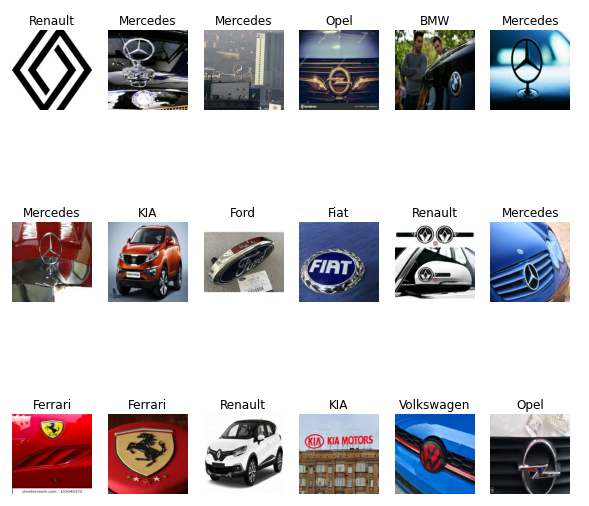

Nous avons décidé de partitionner les images de la manière suivante : 80% pour l’apprentissage, 10% pour la validation et 10% pour les tests. Etant donné que chaque classe contient des images différentes, nous avons donc choisi d’attribuer la majeure partie de la base de données à l’apprentissage.

Pour cela nous allons utiliser une base de données de 4485 images, réparties en 3613 images d'apprentissage, 436 images de validation, et 436 images de test. 

In [1]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.optimizers import Adam

#Chargement des données

On a réparti les images en 3 ensembles (et donc 3 dossiers): train (de 400 images jusqu'à 800 par classe), validation (50 images par classe) et test (50 images par classe). Chacun de ces dossiers comporte un sous-dossier par classe, qui contient les images correspondantes.

On a choisi d'héberger notre base de données sur Github.

In [2]:
!git clone https://github.com/oussama-echcherqaoui/DeepLearning.git
path = "./DeepLearning/"

Cloning into 'DeepLearning'...
remote: Enumerating objects: 9128, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 9128 (delta 9), reused 37 (delta 6), pack-reused 9088
Receiving objects: 100% (9128/9128), 3.00 GiB | 44.05 MiB/s, done.
Resolving deltas: 100% (105/105), done.
Checking out files: 100% (7229/7229), done.


Définition de quelques paramètres pour le chargeur de données

In [3]:
batch_size = 32
image_size = 150

#Utilisation de 2 classes : Ford & Renault:

Afin d'arriver à comprendre mieux le mécanisme de travail, on a fait le choix de commencer par 2 classes et essayer d'méliorer les résultats sur ces deux et puis passer à 10 classes.

Les images de ces deux classes sont mises dans un dossier Test2Classes dans le dépot Github. 

###Prétraitement des images

In [4]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  './DeepLearning/Test2Classes/Train',
  image_size=(image_size, image_size),
  batch_size=batch_size)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
  './DeepLearning/Test2Classes/Validation',
  image_size=(image_size, image_size),
  batch_size=batch_size)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
  './DeepLearning/Test2Classes/Test',
  image_size=(image_size, image_size),
  batch_size=batch_size)


Found 730 files belonging to 2 classes.
Found 90 files belonging to 2 classes.
Found 89 files belonging to 2 classes.


Les labels des classes traitées

In [5]:
class_names = train_data.class_names
print(class_names)

['Ford', 'Renault']


Affichaghe d'images aléatoires de la base de données :

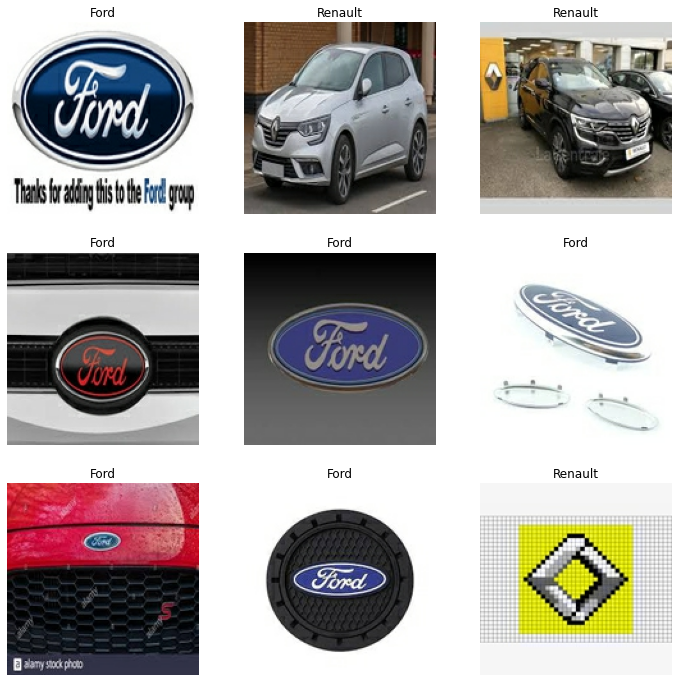

In [6]:
plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##Première approche : réseau convolutif de base

Les images ont toutes été redimensionnées en $150\times150$. Nous pouvons donc définir notre réseau de neurones convolutif en suivant ce schéma : 

<center> <img src="https://drive.google.com/uc?id=1bwXaIgO-pKJGs6fVaX0IrLbFbUAlTvNM" style="width:800;height:400px;"></center>

Ce réseau alterne dans une première phase les couches de convolution et de Max Pooling (afin de diviser à chaque fois la dimension des tenseurs par 2). 

La première couche comptera 32 filtres de convolution, la seconde 64, la troisième 96 et la 4e 128. Enfin, avant la couche de sortie, il y a une couche dense comptant 512 neurones.

In [6]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  

model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(1, activation='sigmoid'))   # Couche de sortie

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

###Entrainement

On choisit optimizers.Adam et vu qu'on travaille avec deux classes pour l'instant, on choisit binary crossentropy loss function. Pour afficher la précision de la formation et de la validation pour chaque période de formation. 

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=3e-4),
              metrics=['acc'])

In [8]:
history = model.fit(train_data, validation_data=validation_data, epochs=20)

Epoch 1/20
23/23 [==============================] - 35s 86ms/step - loss: 24.4974 - acc: 0.4928 - val_loss: 0.6515 - val_acc: 0.5889
Epoch 2/20
23/23 [==============================] - 1s 50ms/step - loss: 0.5244 - acc: 0.7195 - val_loss: 0.5937 - val_acc: 0.7111
Epoch 3/20
23/23 [==============================] - 1s 49ms/step - loss: 0.3730 - acc: 0.8494 - val_loss: 0.6373 - val_acc: 0.7111
Epoch 4/20
23/23 [==============================] - 1s 50ms/step - loss: 0.2134 - acc: 0.9074 - val_loss: 0.6548 - val_acc: 0.7556
Epoch 5/20
23/23 [==============================] - 1s 48ms/step - loss: 0.1275 - acc: 0.9510 - val_loss: 0.6622 - val_acc: 0.7444
Epoch 6/20
23/23 [==============================] - 1s 48ms/step - loss: 0.0704 - acc: 0.9879 - val_loss: 0.6422 - val_acc: 0.7889
Epoch 7/20
23/23 [==============================] - 1s 49ms/step - loss: 0.0419 - acc: 0.9926 - val_loss: 0.7601 - val_acc: 0.7778
Epoch 8/20
23/23 [==============================] - 1s 50ms/step - loss: 0.0156 -

###Analyse des résultats du modèle

In [9]:
def plot_training_analysis():
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss'][1:]
  val_loss = history.history['val_loss'][1:]


  epochs = range(len(acc))
  epochs_loss = range(len(loss))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs_loss, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs_loss, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

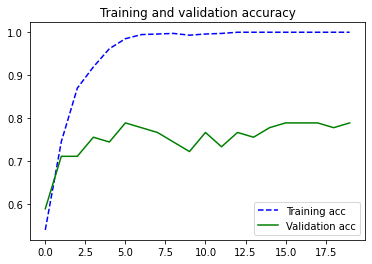

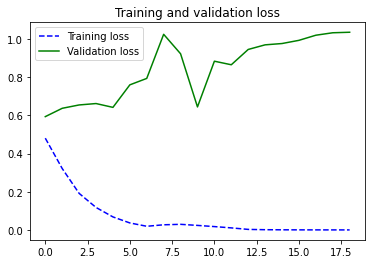

In [10]:
plot_training_analysis()

On remarque qu'on a un problème de surapprentissage. Ce problème est classique dès lors que l'on travaille sur des bases de données de taille réduite en apprentissage profond, ce qui est le cas pour nous. En effet, le réseau que nous avons créé compte plus de trois millions de paramètres. Le problème que nous essayons de résoudre pendant l'entraînement consiste à établir 3 millions de paramètres avec seulement 730 exemples : c'est trop peu !


###Correction du surapprentissage

Afin de limiter le surapprentissage, on va appliquer en premier la techniques de l'augmentation de la base de données.

Nous allons donc utiliser un ImageDataGenerator pour normaliser les images et l'utiliser pour appliquer des transformations supplémentaires aux images de notre base de données.

In [41]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './DeepLearning/Test2Classes/Train',
        target_size=(image_size, image_size),
        batch_size= batch_size,)
        #class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        './DeepLearning/Test2Classes/Validation',
        target_size=(image_size, image_size),
        batch_size= batch_size,)
        #class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        './DeepLearning/Test2Classes/Test',
        target_size=(image_size, image_size),
        batch_size= batch_size)
        #class_mode='binary')

Found 730 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Found 89 images belonging to 2 classes.


In [42]:
train_generator.class_indices

{'Ford': 0, 'Renault': 1}

In [43]:
labels = {0 :'Ford', 1 : 'Renault'}
labels

{0: 'Ford', 1: 'Renault'}

In [44]:
model = models.Sequential()
# A COMPLETER
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  

model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(2, activation='sigmoid'))   # Couche de sortie

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=3e-4),
              metrics=['acc'])

history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 34, 34, 96)        55392     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 15, 15, 128)      

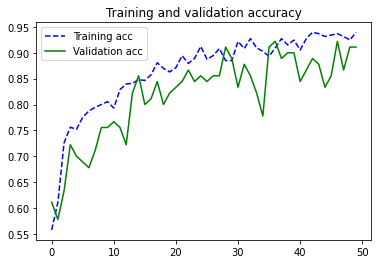

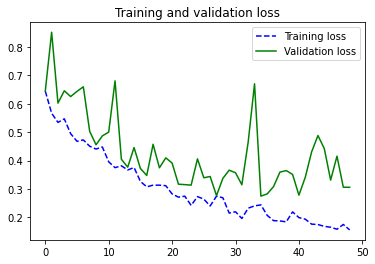

In [45]:
plot_training_analysis()

##Utilisation de Callbacks et de checkpoints

In [47]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  

model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(2, activation='sigmoid'))   # Couche de sortie

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=3e-4),
              metrics=['acc'])

from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc1 = ModelCheckpoint('models.h5', monitor='val_loss', mode='min', verbose=1)
mc2 = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[es,mc1,mc2])

Epoch 1/50
23/23 [==============================] - 5s 198ms/step - loss: 0.6906 - acc: 0.5719 - val_loss: 0.7812 - val_acc: 0.5778

Epoch 00001: saving model to models.h5

Epoch 00001: val_loss improved from inf to 0.78122, saving model to best_model.h5
Epoch 2/50
23/23 [==============================] - 4s 195ms/step - loss: 0.6758 - acc: 0.5934 - val_loss: 0.6583 - val_acc: 0.6222

Epoch 00002: saving model to models.h5

Epoch 00002: val_loss improved from 0.78122 to 0.65833, saving model to best_model.h5
Epoch 3/50
23/23 [==============================] - 4s 194ms/step - loss: 0.5794 - acc: 0.6941 - val_loss: 0.7075 - val_acc: 0.5444

Epoch 00003: saving model to models.h5

Epoch 00003: val_loss did not improve from 0.65833
Epoch 4/50
23/23 [==============================] - 4s 192ms/step - loss: 0.6041 - acc: 0.6669 - val_loss: 0.7431 - val_acc: 0.6444

Epoch 00004: saving model to models.h5

Epoch 00004: val_loss did not improve from 0.65833
Epoch 5/50
23/23 [====================

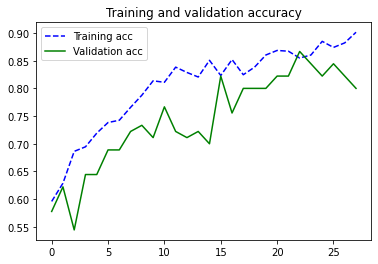

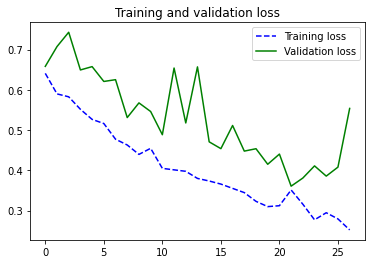

In [48]:
plot_training_analysis()

In [49]:
from keras.models import load_model
best_model = load_model('best_model.h5')

scores = model.evaluate(test_generator) # let's look at the accuracy on the test set
print("Accuracy test: %.2f%%" % (scores[1]*100))

3/3 [==============================] - 0s 33ms/step - loss: 0.2504 - acc: 0.9326
Accuracy test: 93.26%


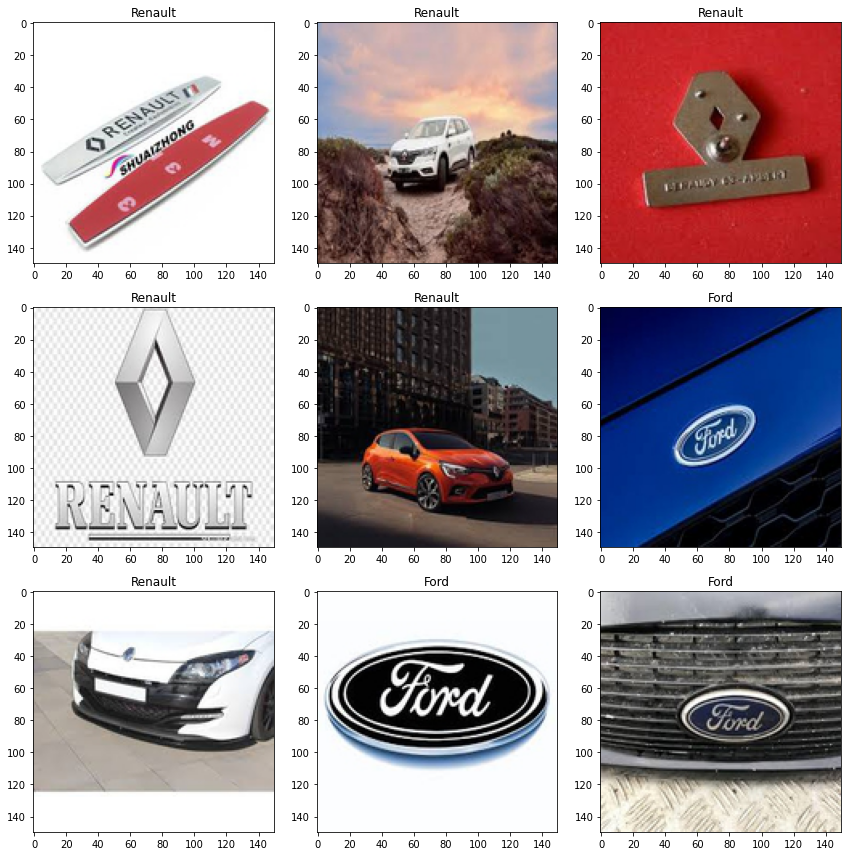

In [31]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in test_generator:
        image = X_batch[0]
        plt.title(labels.get(Y_batch[0]))
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [51]:
predicted_label_probs = model.predict(test_generator)
predicted_labels = np.argmax(predicted_label_probs, axis=1)

true_labels = test_generator.classes

In [52]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(true_labels, predicted_labels)))

print('Micro Precision: {:.2f}'.format(precision_score(true_labels, predicted_labels, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(true_labels, predicted_labels, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(true_labels, predicted_labels, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(true_labels, predicted_labels, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(true_labels, predicted_labels, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(true_labels, predicted_labels, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(true_labels, predicted_labels, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(true_labels, predicted_labels, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(true_labels, predicted_labels, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(true_labels, predicted_labels, target_names=['Ford', 'Renault']))

Confusion Matrix

[[17 20]
 [26 26]]

Accuracy: 0.48

Micro Precision: 0.48
Micro Recall: 0.48
Micro F1-score: 0.48

Macro Precision: 0.48
Macro Recall: 0.48
Macro F1-score: 0.48

Weighted Precision: 0.49
Weighted Recall: 0.48
Weighted F1-score: 0.49

Classification Report

              precision    recall  f1-score   support

        Ford       0.40      0.46      0.42        37
     Renault       0.57      0.50      0.53        52

    accuracy                           0.48        89
   macro avg       0.48      0.48      0.48        89
weighted avg       0.49      0.48      0.49        89



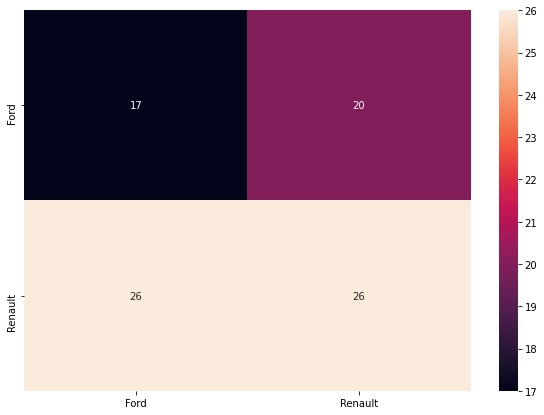

In [53]:
import seaborn as sns
import pandas as pd



df_cm = pd.DataFrame(confusion, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

This image most likely belongs to Renault with a 73.11 percent confidence.


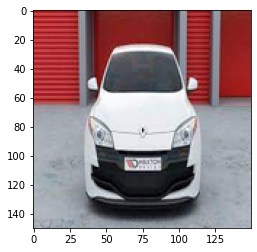

In [59]:
import matplotlib.image as mpimg

path_img = "./DeepLearning/Test2Classes/Test/Renault/Renault.33.jpg"

plt.imshow(mpimg.imread(path_img))

img = keras.preprocessing.image.load_img(
    path_img, target_size=(150, 150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

#Utilisation de toutes les classes :

In [60]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen1 = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator1 = train_datagen.flow_from_directory(
        './DeepLearning/Train',
        target_size=(image_size, image_size),
        batch_size= batch_size,
        class_mode='categorical')

validation_generator1 = test_datagen.flow_from_directory(
        './DeepLearning/Validation',
        target_size=(image_size, image_size),
        batch_size= batch_size,
        class_mode='categorical')

test_generator1 = test_datagen.flow_from_directory(
        './DeepLearning/Test',
        target_size=(image_size, image_size),
        batch_size= batch_size,
        class_mode='categorical')

Found 3613 images belonging to 10 classes.
Found 436 images belonging to 10 classes.
Found 436 images belonging to 10 classes.


In [61]:
model = models.Sequential()
# A COMPLETER
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu',padding='same'))
model.add(Conv2D(32, (3, 3),padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(Dropout(0.5))
x=model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  

model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones

# final activation is softmax, tuned to the number of classes/labels possible
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=3e-4),
              metrics=['acc'])

from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc1 = ModelCheckpoint('models.h5', monitor='val_loss', mode='min', verbose=1)
mc2 = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(
        train_generator1,
        epochs=50,
        validation_data=validation_generator1,
        callbacks=[es,mc1,mc2])

Epoch 1/50
113/113 [==============================] - 25s 210ms/step - loss: 2.1853 - acc: 0.2203 - val_loss: 2.0126 - val_acc: 0.3280

Epoch 00001: saving model to models.h5

Epoch 00001: val_loss improved from inf to 2.01260, saving model to best_model.h5
Epoch 2/50
113/113 [==============================] - 23s 201ms/step - loss: 1.9368 - acc: 0.3271 - val_loss: 1.9002 - val_acc: 0.3899

Epoch 00002: saving model to models.h5

Epoch 00002: val_loss improved from 2.01260 to 1.90019, saving model to best_model.h5
Epoch 3/50
113/113 [==============================] - 23s 203ms/step - loss: 1.8089 - acc: 0.3838 - val_loss: 1.7912 - val_acc: 0.4358

Epoch 00003: saving model to models.h5

Epoch 00003: val_loss improved from 1.90019 to 1.79124, saving model to best_model.h5
Epoch 4/50
113/113 [==============================] - 23s 203ms/step - loss: 1.7238 - acc: 0.4201 - val_loss: 1.7033 - val_acc: 0.4243

Epoch 00004: saving model to models.h5

Epoch 00004: val_loss improved from 1.7912

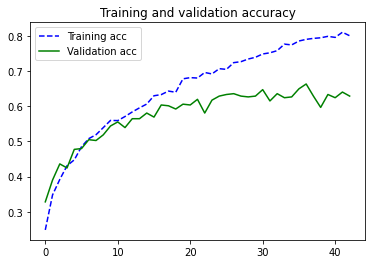

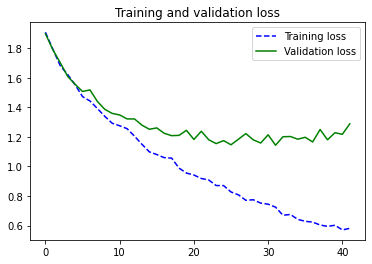

In [63]:
plot_training_analysis()

In [64]:
from keras.models import load_model
best_model1 = load_model('best_model.h5')

scores = best_model1.evaluate(test_generator1) # let's look at the accuracy on the test set
print("Accuracy test: %.2f%%" % (scores[1]*100))

14/14 [==============================] - 1s 49ms/step - loss: 0.9938 - acc: 0.6995
Accuracy test: 69.95%


In [ ]:
predicted_label_probs = best_model1.predict(test_generator1)
predicted_labels = np.argmax(predicted_label_probs, axis=1)

true_labels = test_generator1.classes

In [79]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(true_labels, predicted_labels)))

print('Micro Precision: {:.2f}'.format(precision_score(true_labels, predicted_labels, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(true_labels, predicted_labels, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(true_labels, predicted_labels, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(true_labels, predicted_labels, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(true_labels, predicted_labels, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(true_labels, predicted_labels, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(true_labels, predicted_labels, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(true_labels, predicted_labels, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(true_labels, predicted_labels, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(true_labels, predicted_labels, target_names=train_generator1.class_indices.keys()))

Confusion Matrix

[[22  7  6  5  4  4  9  1 25  5]
 [ 5  1  1  6  2  0  4  2  4  2]
 [ 5  3  4  2  0  0  5  0  6  2]
 [ 5  1  4  4  1  2  9  2  9  1]
 [ 2  0  0  2  2  0 10  1  2  1]
 [ 8  3  2  3  3  1  0  0  3  2]
 [19  4  9  9  2  6 25  2  9  9]
 [ 5  3  0  3  1  2  7  2  0  2]
 [ 8  9  2  5  1  1 13  0  8  5]
 [ 5  0  3  7  1  4 11  2  5  2]]

Accuracy: 0.16

Micro Precision: 0.16
Micro Recall: 0.16
Micro F1-score: 0.16

Macro Precision: 0.13
Macro Recall: 0.12
Macro F1-score: 0.12

Weighted Precision: 0.17
Weighted Recall: 0.16
Weighted F1-score: 0.16

Classification Report

              precision    recall  f1-score   support

         BMW       0.26      0.25      0.26        88
     Ferrari       0.03      0.04      0.03        27
        Fiat       0.13      0.15      0.14        27
        Ford       0.09      0.11      0.10        38
      Jaguar       0.12      0.10      0.11        20
         KIA       0.05      0.04      0.04        25
    Mercedes       0.27      0.27 

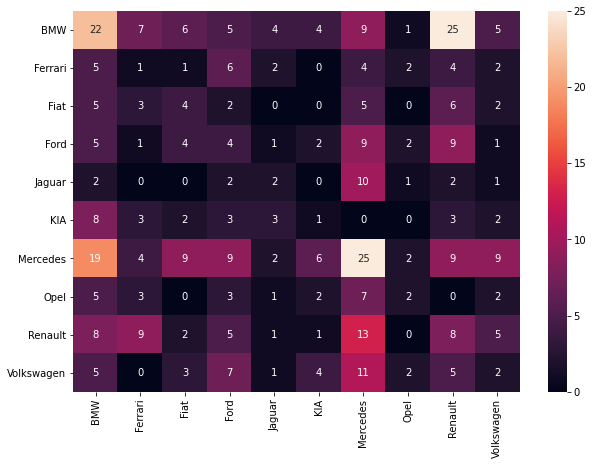

In [82]:
import seaborn as sns
import pandas as pd

classes = train_generator1.class_indices.keys()

df_cm = pd.DataFrame(confusion, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

#Fine-tuning

In [83]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [84]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [85]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), # Taux d'apprentissage réduit pour ne pas tout casser, ni risquer le sur-apprentissage !
              metrics=['acc'])

In [86]:
history = model.fit(
        train_generator1,
        epochs=50,
        validation_data=validation_generator1)

Epoch 1/50
113/113 [==============================] - 43s 328ms/step - loss: 1.9566 - acc: 0.3246 - val_loss: 1.0476 - val_acc: 0.6927
Epoch 2/50
113/113 [==============================] - 30s 261ms/step - loss: 1.0420 - acc: 0.6679 - val_loss: 0.7794 - val_acc: 0.7500
Epoch 3/50
113/113 [==============================] - 29s 260ms/step - loss: 0.7923 - acc: 0.7655 - val_loss: 0.7066 - val_acc: 0.7844
Epoch 4/50
113/113 [==============================] - 30s 261ms/step - loss: 0.6614 - acc: 0.7888 - val_loss: 0.6295 - val_acc: 0.8165
Epoch 5/50
113/113 [==============================] - 30s 261ms/step - loss: 0.4922 - acc: 0.8481 - val_loss: 0.6052 - val_acc: 0.8188
Epoch 6/50
113/113 [==============================] - 29s 260ms/step - loss: 0.4685 - acc: 0.8472 - val_loss: 0.6769 - val_acc: 0.8119
Epoch 7/50
113/113 [==============================] - 30s 260ms/step - loss: 0.4332 - acc: 0.8661 - val_loss: 0.5015 - val_acc: 0.8303
Epoch 8/50
113/113 [==============================] - 2

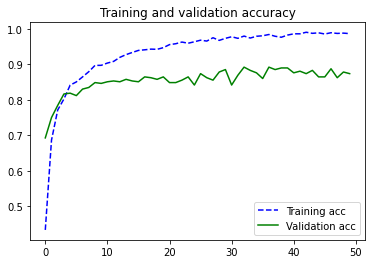

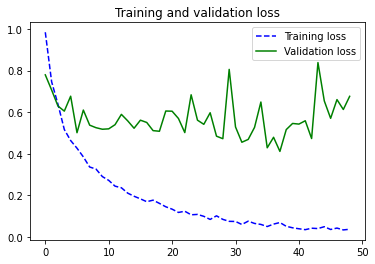

In [87]:
plot_training_analysis()

In [89]:
scores = model.evaluate(test_generator1) # let's look at the accuracy on the test set
print("Accuracy test: %.2f%%" % (scores[1]*100))

14/14 [==============================] - 1s 70ms/step - loss: 0.5372 - acc: 0.9106
Accuracy test: 91.06%


In [90]:
predicted_label_probs = model.predict(test_generator1)
predicted_labels = np.argmax(predicted_label_probs, axis=1)

true_labels = test_generator1.classes

In [91]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(true_labels, predicted_labels)))

print('Micro Precision: {:.2f}'.format(precision_score(true_labels, predicted_labels, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(true_labels, predicted_labels, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(true_labels, predicted_labels, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(true_labels, predicted_labels, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(true_labels, predicted_labels, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(true_labels, predicted_labels, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(true_labels, predicted_labels, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(true_labels, predicted_labels, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(true_labels, predicted_labels, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(true_labels, predicted_labels, target_names=train_generator1.class_indices.keys()))

Confusion Matrix

[[17 10  6  6  4  2 20  4 12  7]
 [ 6  2  1  2  0  1  6  1  6  2]
 [ 4  0  2  3  2  1  9  0  5  1]
 [ 2  3  6  5  2  0  9  1  7  3]
 [ 1  0  1  2  0  3  3  2  4  4]
 [ 2  2  3  3  0  2  5  0  2  6]
 [24  5  4  7  7  4 18  5 11  9]
 [ 8  1  1  1  2  2  5  0  4  1]
 [10  2  3  4  4  1 18  4  5  1]
 [11  1  1  7  1  5  4  1  5  4]]

Accuracy: 0.13

Micro Precision: 0.13
Micro Recall: 0.13
Micro F1-score: 0.13

Macro Precision: 0.09
Macro Recall: 0.09
Macro F1-score: 0.09

Weighted Precision: 0.13
Weighted Recall: 0.13
Weighted F1-score: 0.13

Classification Report

              precision    recall  f1-score   support

         BMW       0.20      0.19      0.20        88
     Ferrari       0.08      0.07      0.08        27
        Fiat       0.07      0.07      0.07        27
        Ford       0.12      0.13      0.13        38
      Jaguar       0.00      0.00      0.00        20
         KIA       0.10      0.08      0.09        25
    Mercedes       0.19      0.19 

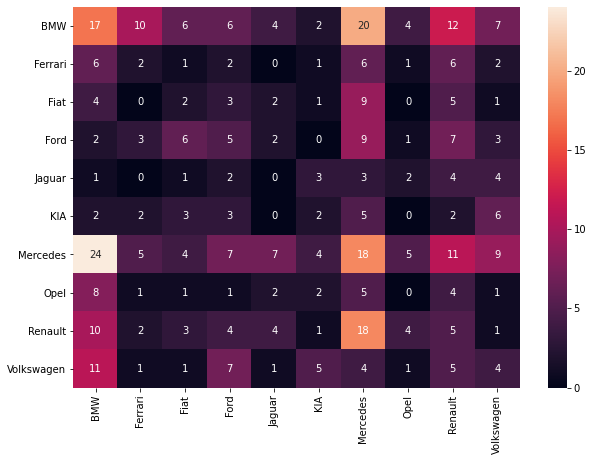

In [92]:
import seaborn as sns
import pandas as pd

classes = train_generator1.class_indices.keys()

df_cm = pd.DataFrame(confusion, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)